In [1]:
CV = 10

In [2]:
import os
from os.path import join
import pandas as pd

input_data_dir = os.environ["DATA"] + "/01_space_enumeration/csv_qm/" 

categories = ["Alone", "btx", "naphtalene", "tetracene"]

# Reading data
cat_dataframes = []
for category in categories:
    cat_dataframes.append(pd.read_csv(join(input_data_dir, category + ".csv"), delimiter=";", usecols=range(7)))
    
# Labelling data with input file
for i in range(len(categories)):
    cat_dataframes[i]["from"] = categories[i]
    
# Merging all dataframes
complete_df = pd.concat(cat_dataframes)
complete_df = complete_df[complete_df["pass"] == "PASS"]

cat_dataframes_prefixed = []
# Creating complete dataframe with prefixed properties
for i in range(len(cat_dataframes)):
    curr_df = pd.DataFrame()
    for k in complete_df.keys():
        if k == "id":
            curr_df["id"] = cat_dataframes[i]["id"]
        elif k != "from":
            curr_df[categories[i] + "_" + k] = cat_dataframes[i][k]
            
    if i == 0:
        complete_df_prefixed = curr_df
    else:
        complete_df_prefixed = pd.merge(complete_df_prefixed, curr_df, on="id")


# Removing lines containing nan values
complete_df_prefixed.dropna(inplace=True)


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, make_scorer
import numpy as np

def absolute_error(y_pred, y_true):
    return np.array(y_pred - y_true)

def train_evaluate_model(data_pd, model, X_keys, y_key, cv):

    # Extracting data
    X = data_pd[X_keys].to_numpy()
    y = data_pd[y_key].to_numpy()
    
    folds_idx = list(KFold(cv).split(X))
    
    models_abs_errors = []
    models_MAEs = []
    models_test_idx = []
    
    # Iterating over folds
    for curr_fold_idx in folds_idx:
        curr_train_idx, curr_test_idx = curr_fold_idx
        
        # Training current fold model
        model.fit(X[curr_train_idx], y[curr_train_idx])
        
        # Testing trained model
        y_pred = model.predict(X[curr_test_idx])
        
        # Computing errors for current model
        models_abs_errors.append(np.abs(y[curr_test_idx] - y_pred))
        
        # Computing MAE of current model
        models_MAEs.append(mean_absolute_error(y[curr_test_idx], y_pred))
        
        # Recording indices of test data
        models_test_idx.append(curr_test_idx)

    return models_MAEs, models_abs_errors, models_test_idx

def MAE_stats(maes):
    print("Mean : " + str(np.mean(maes)))
    print("Med : " + str(np.median(maes)))
    print("Stddev : " + str(np.std(maes)))
    print("Min : " + str(np.min(maes)))
    print("Max : " + str(np.max(maes)))
    

In [4]:
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_MAE_hist(model_names, model_MAEs):

    plt.figure(figsize=(15, 10))
    plt.xlabel("MAE")
    
    # Plotting MAE histogram
    for i in range(len(model_names)):
        sns.kdeplot(model_MAEs[i], label=model_names[i])

def plot_abs_errors_hist(model_names, model_abs_errors):

    plt.figure(figsize=(15, 10))
    plt.xlabel("Absolute error")
        
    # Plotting MAE histogram
    for i in range(len(model_names)):
        sns.kdeplot(model_abs_errors[i], label=model_names[i])
        
def train_evaluate_models(data_pd, model, X_keys, y_key, cv=10):

    # Generating all models
    model_names = []
    model_X_keys = []
    for i in range(1, len(X_keys) + 1):
        model_combinations = combinations(X_keys, r=i)
        for curr_X_keys in model_combinations:
           
            model_name_list = [x_key.split("_")[0] for x_key in curr_X_keys]
            model_name = "_".join(model_name_list)
            model_names.append(model_name)
            model_X_keys.append([x_key for x_key in curr_X_keys])
                
    # Training all models
    models_MAEs = []
    models_abs_errors = []
    models_test_idx = []
    
    for i in range(len(model_names)):
        curr_model_MAEs, curr_model_abs_errors, curr_model_test_idx = train_evaluate_model(data_pd, model, 
                                                                                       model_X_keys[i], y_key, 
                                                                                       cv=cv)
        models_MAEs.append(curr_model_MAEs)
        models_abs_errors.append(np.concatenate(curr_model_abs_errors))
        models_test_idx.append(curr_model_test_idx)

    for i in range(len(model_names)):
        print(model_names[i] +" Absolute errors")
        MAE_stats(models_abs_errors[i])
        print("\n\n")
        
    # Plotting MAE hist
    plot_MAE_hist(model_names, models_MAEs)
    
    # Plotting Absolute errors hist
    plot_abs_errors_hist(model_names, models_abs_errors)
    
    


## Linear model

### HOMO prediction

Alone Absolute errors
Mean : 0.00402297523019737
Med : 0.0033776318066918443
Stddev : 0.0031744962844289766
Min : 1.6536499158892326e-07
Max : 0.031848958962078566



naphtalene Absolute errors
Mean : 0.0033788184513003088
Med : 0.002682127345496027
Stddev : 0.0028598984561057205
Min : 5.84073460513368e-07
Max : 0.03221583119709298



tetracene Absolute errors
Mean : 0.0038080183111838467
Med : 0.0028852386875971303
Stddev : 0.003569269332263966
Min : 8.21934861977569e-07
Max : 0.03957344810297958



Alone_naphtalene Absolute errors
Mean : 0.003383568276149236
Med : 0.002741201692458173
Stddev : 0.002808976438968894
Min : 5.3692772200575334e-08
Max : 0.030877945618318192



Alone_tetracene Absolute errors
Mean : 0.0035008759887987816
Med : 0.002787077608654348
Stddev : 0.0029697877197380415
Min : 4.401021198585653e-07
Max : 0.033466037400301435



naphtalene_tetracene Absolute errors
Mean : 0.00316774862791064
Med : 0.0024559670167101644
Stddev : 0.0028100205691511154
Min : 9.019086148

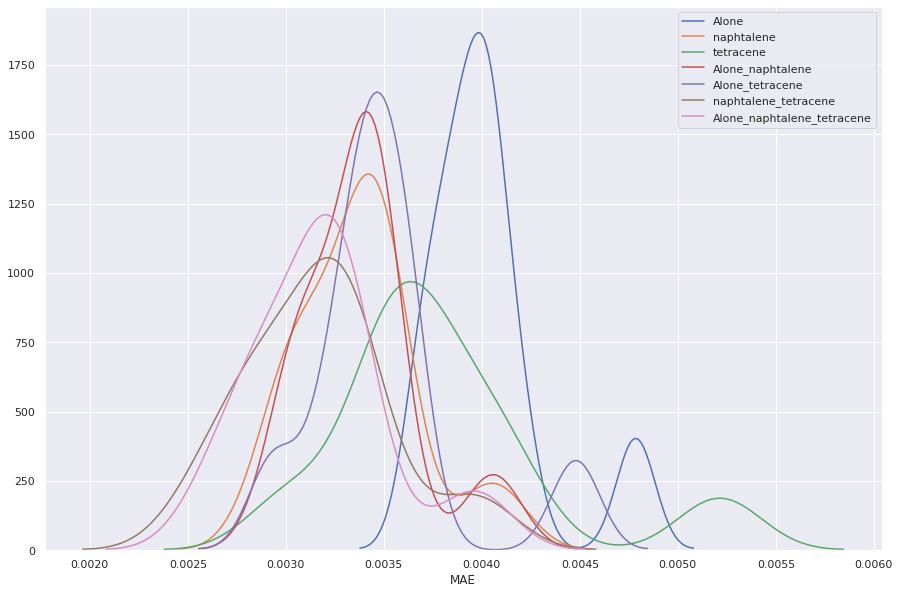

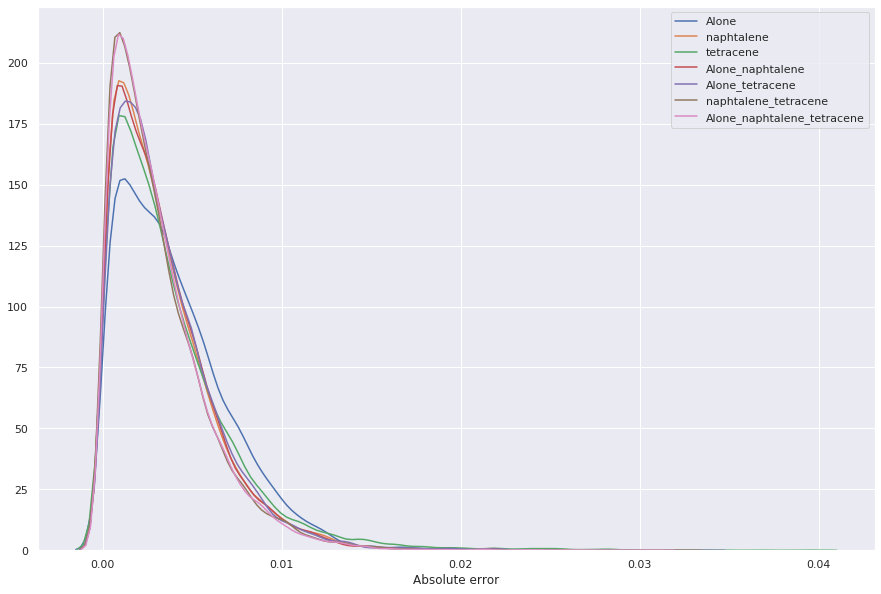

In [5]:
train_evaluate_models(complete_df_prefixed, LinearRegression(), ["Alone_homo", "naphtalene_homo", "tetracene_homo"], 
                            "btx_homo", cv=CV)


### LUMO prediction

Alone Absolute errors
Mean : 0.00605099367644435
Med : 0.0049750284264476335
Stddev : 0.0049342378452508495
Min : 2.6949247275420696e-06
Max : 0.04921111154365582



naphtalene Absolute errors
Mean : 0.0055532057623781305
Med : 0.004546099052341504
Stddev : 0.004474592741638572
Min : 1.0946793120025777e-06
Max : 0.052768615539180386



tetracene Absolute errors
Mean : 0.0042472335862823755
Med : 0.003243180219733216
Stddev : 0.0037893275724631506
Min : 4.193775899469232e-07
Max : 0.0372702307097908



Alone_naphtalene Absolute errors
Mean : 0.005453171026363988
Med : 0.004468335191958647
Stddev : 0.0044064616193987965
Min : 9.352597345191338e-08
Max : 0.05198454727933352



Alone_tetracene Absolute errors
Mean : 0.0042330264051067025
Med : 0.0033049174223541006
Stddev : 0.003674723350331962
Min : 2.669969593277477e-06
Max : 0.03642591451493553



naphtalene_tetracene Absolute errors
Mean : 0.004253475179477235
Med : 0.0033682362033348734
Stddev : 0.0036586090031358494
Min : 8.480193555

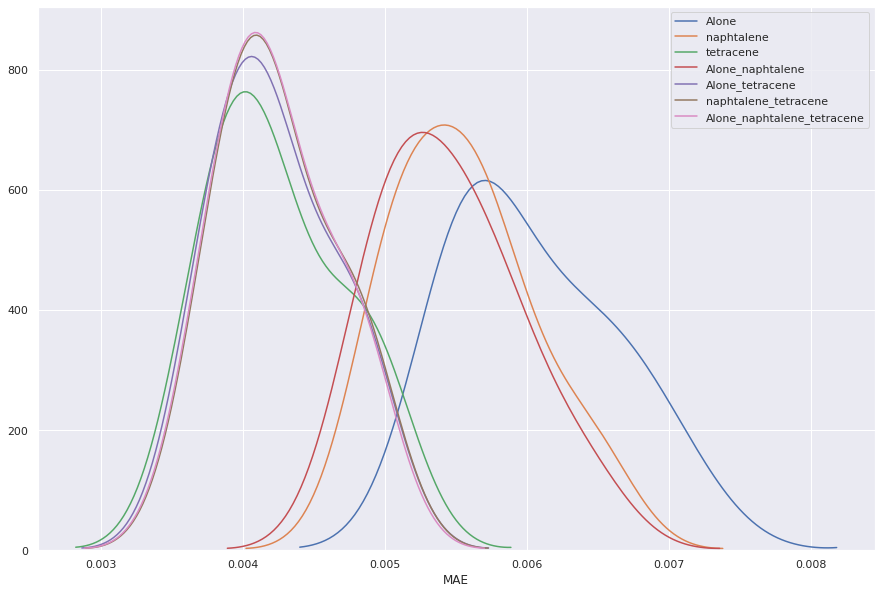

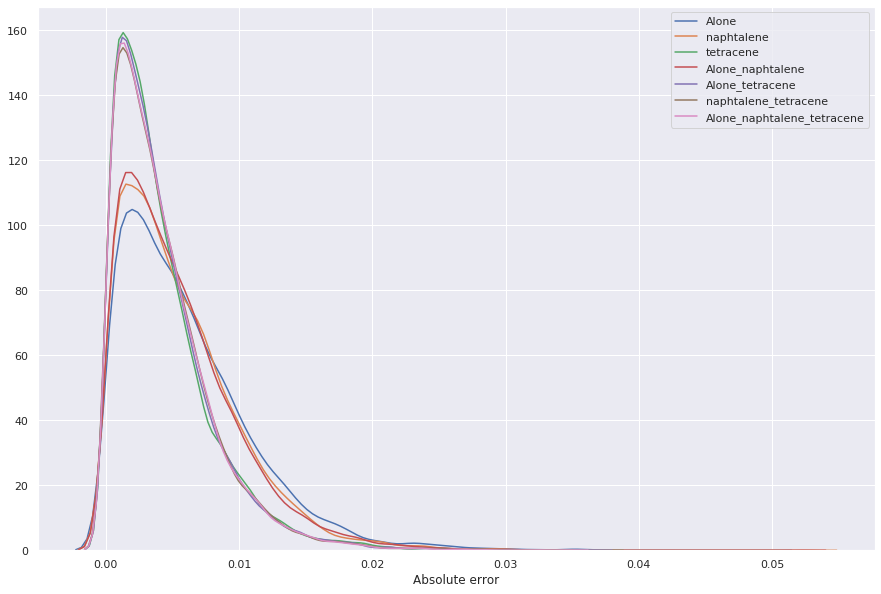

In [6]:
train_evaluate_models(complete_df_prefixed, LinearRegression(), ["Alone_lumo", "naphtalene_lumo", "tetracene_lumo"], 
                            "btx_lumo", cv=CV)

### Lambda prediction 

Alone Absolute errors
Mean : 46.534187718643444
Med : 35.473408597479306
Stddev : 48.90217083632268
Min : 0.0054270823054594075
Max : 874.2961554870006



naphtalene Absolute errors
Mean : 33.25390124768601
Med : 23.726206046879554
Stddev : 35.873642920778074
Min : 0.005165683905090646
Max : 434.090721520951



tetracene Absolute errors
Mean : 29.67706809910186
Med : 19.827449330870934
Stddev : 38.844589875035
Min : 0.002289062511579232
Max : 1417.2637376764294



Alone_naphtalene Absolute errors
Mean : 33.28471176736816
Med : 23.777753799159996
Stddev : 35.88436102783657
Min : 0.017917253331972915
Max : 441.9151522749821



Alone_tetracene Absolute errors
Mean : 28.678329076495242
Med : 18.743485105476736
Stddev : 38.18234964616866
Min : 0.0007974190539243864
Max : 1349.8086244575195



naphtalene_tetracene Absolute errors
Mean : 27.4933447605741
Med : 18.436069403751617
Stddev : 33.773400825564494
Min : 7.725699663296837e-05
Max : 901.3898362889902



Alone_naphtalene_tetracene Absol

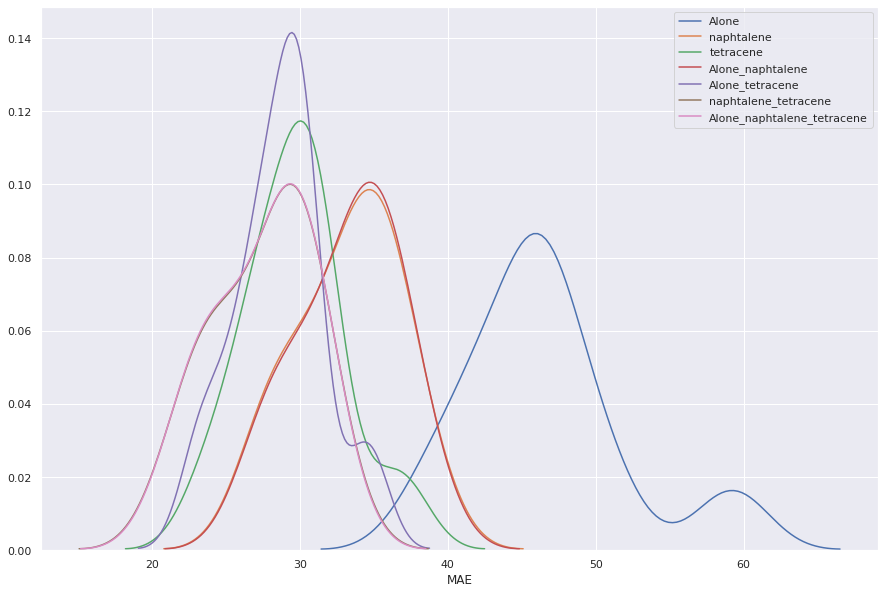

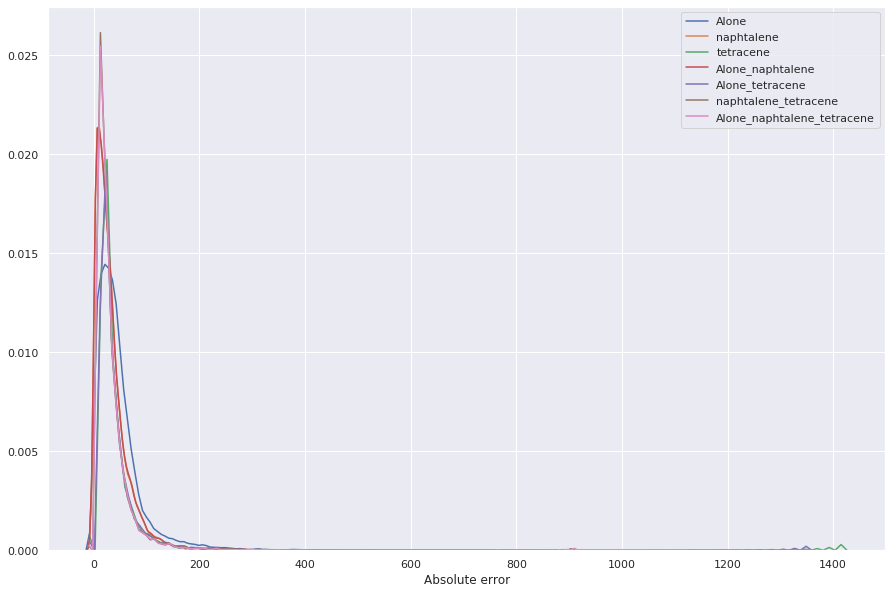

In [7]:
train_evaluate_models(complete_df_prefixed, LinearRegression(), ["Alone_lambda", "naphtalene_lambda", "tetracene_lambda"], 
                            "btx_lambda", cv=CV)

## KRR

### HOMO

Alone Absolute errors
Mean : 0.011681039038278579
Med : 0.01033122518685009
Stddev : 0.008190277667609389
Min : 2.7590187785253573e-06
Max : 0.04805125692816392



naphtalene Absolute errors
Mean : 0.004809556411283249
Med : 0.003730490756729349
Stddev : 0.004153193229712545
Min : 3.952619873626162e-07
Max : 0.03483295141147866



tetracene Absolute errors
Mean : 0.0042127521886318265
Med : 0.0032526460168815774
Stddev : 0.003772898577534576
Min : 4.938389777942032e-07
Max : 0.03892838820471936



Alone_naphtalene Absolute errors
Mean : 0.0059326668040525846
Med : 0.005009371540645929
Stddev : 0.004538962607248346
Min : 1.2714585522211053e-06
Max : 0.03264483683485295



Alone_tetracene Absolute errors
Mean : 0.004881725946244729
Med : 0.004179292556740044
Stddev : 0.0036110226620910658
Min : 8.883530609182788e-07
Max : 0.025232513039524285



naphtalene_tetracene Absolute errors
Mean : 0.0035232051462496237
Med : 0.0027062050273500837
Stddev : 0.003057359530135051
Min : 1.757909839916

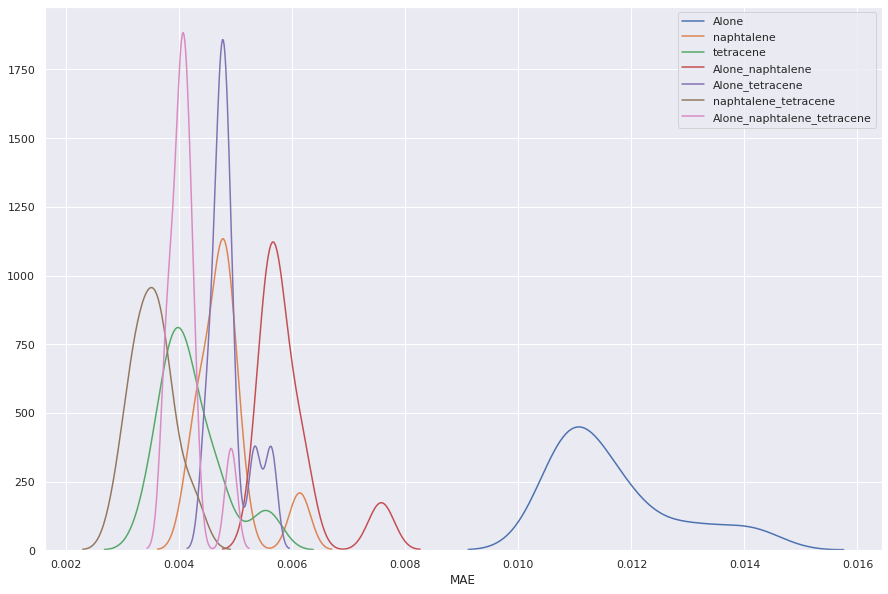

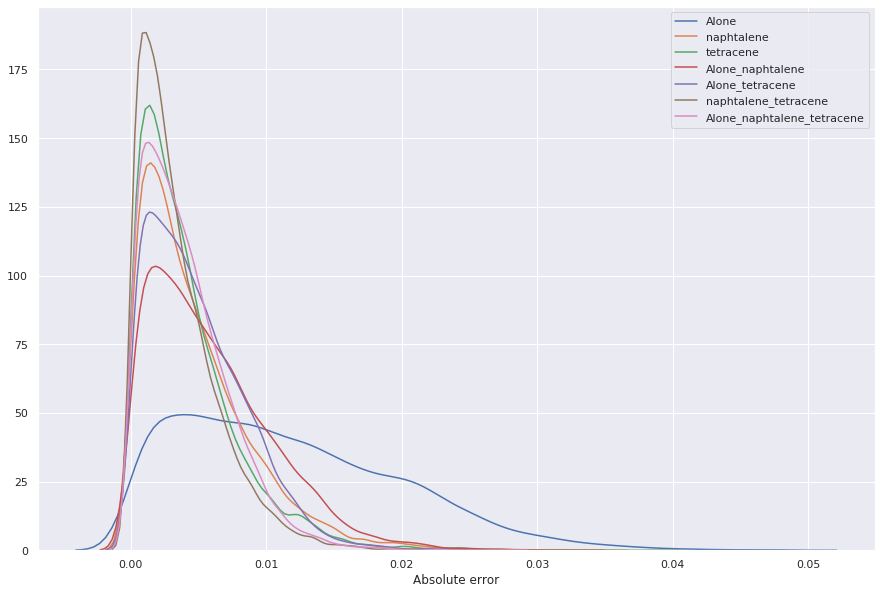

In [8]:
from sklearn.kernel_ridge import KernelRidge

train_evaluate_models(complete_df_prefixed, KernelRidge(), ["Alone_homo", "naphtalene_homo", "tetracene_homo"], 
                            "btx_homo", cv=CV)